<a href="https://colab.research.google.com/github/abishekparajuli-np/FaceEmotionDetection/blob/main/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [65]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf

In [66]:
import kagglehub
path = kagglehub.dataset_download("msambare/fer2013")

Using Colab cache for faster access to the 'fer2013' dataset.


In [67]:
train = f"{path}/train"
test  = f"{path}/test"

In [68]:
image_size=48
batch_size=64
num_classes=7

In [69]:
emotions=['angry','disgust','fear','happy','neutral','sad','surprise']

In [70]:
def count_images(directory):
    counts={}
    for emotion in emotions:
        path = os.path.join(directory,emotion)
        if os.path.exists(path):
            counts[emotion]=len(os.listdir(path))
    return counts

In [71]:
train_counts=count_images(train)
test_counts=count_images(test)

In [72]:
train_counts

{'angry': 3995,
 'disgust': 436,
 'fear': 4097,
 'happy': 7215,
 'neutral': 4965,
 'sad': 4830,
 'surprise': 3171}

In [73]:
test_counts

{'angry': 958,
 'disgust': 111,
 'fear': 1024,
 'happy': 1774,
 'neutral': 1233,
 'sad': 1247,
 'surprise': 831}

In [74]:
#Test and Train Data Distribution Visualization

In [75]:
import matplotlib.pyplot as plt
import seaborn as sna

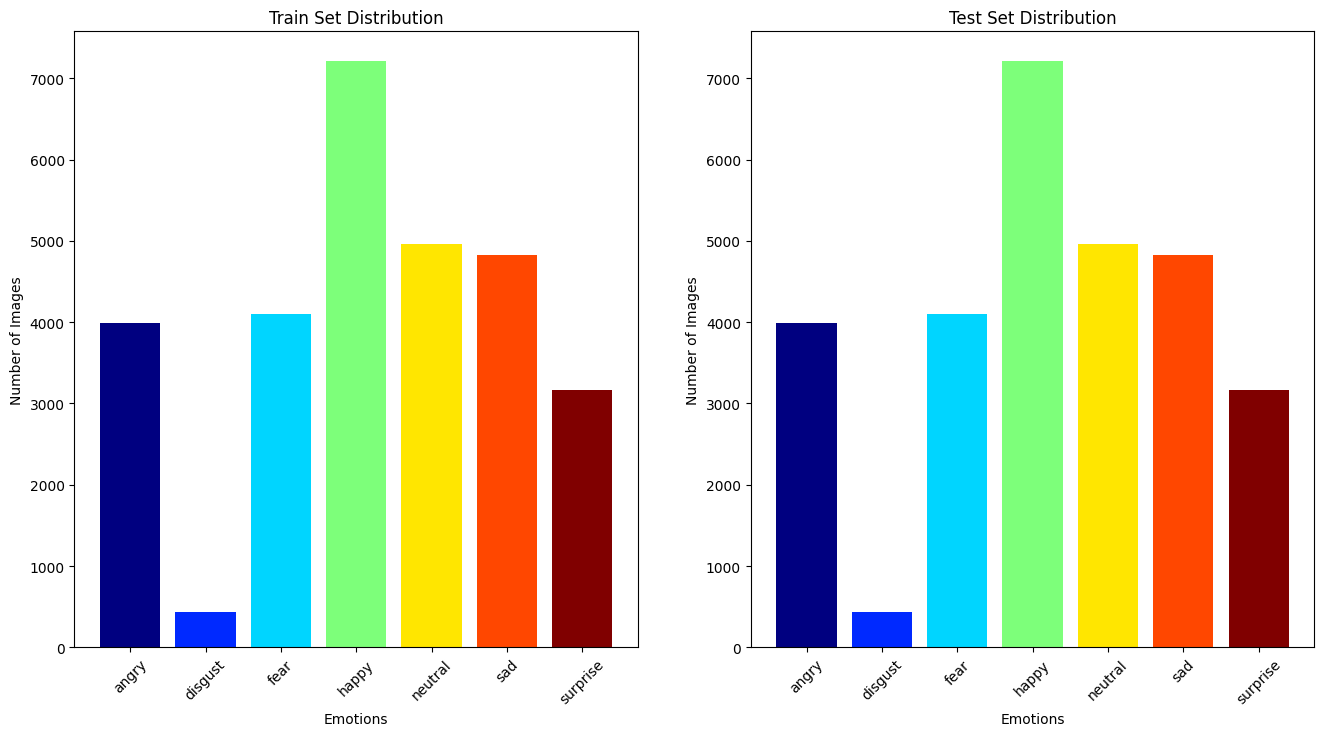

In [76]:
fig,axes=plt.subplots(1,2,figsize=(16,8))
colors=plt.cm.jet(np.linspace(0,1,len(emotions)))

#train_set
ax1=axes[0]
bars1 = ax1.bar(train_counts.keys(),train_counts.values(),color=colors)
ax1.set_title("Train Set Distribution")
ax1.set_xlabel('Emotions')
ax1.set_ylabel('Number of Images')
ax1.tick_params(axis='x',rotation=45)

#test_set
ax2=axes[1]
bars2 = ax2.bar(train_counts.keys(),train_counts.values(),color=colors)
ax2.set_title("Test Set Distribution")
ax2.set_xlabel('Emotions')
ax2.set_ylabel('Number of Images')
ax2.tick_params(axis='x',rotation=45)


plt.show()

In [77]:
print('Most Samples={0}({1})'.format(max(train_counts,key=train_counts.get),max(train_counts.values())))
print('Least Samples={0}({1})'.format(min(train_counts,key=train_counts.get),min(train_counts.values())))

Most Samples=happy(7215)
Least Samples=disgust(436)


In [78]:
#Sample Image for eacg category

In [79]:
import cv2

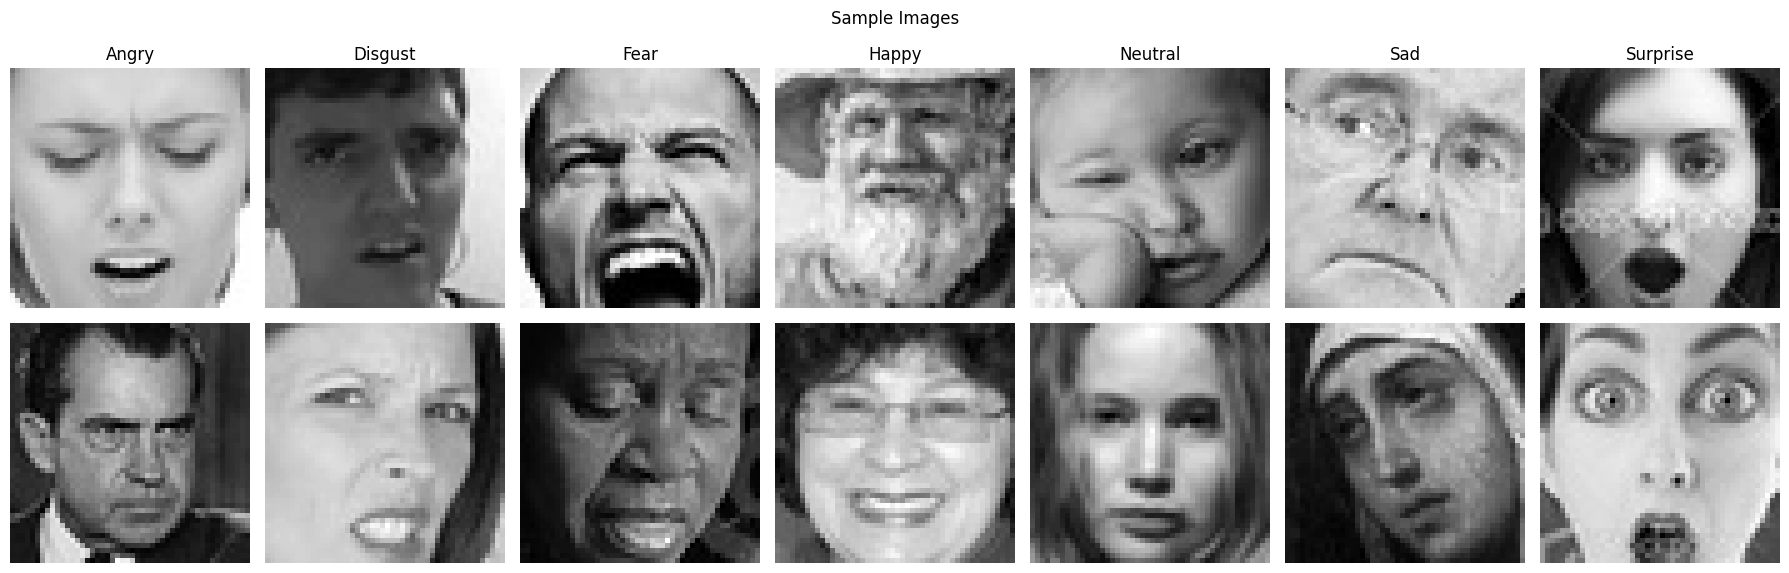

In [80]:
fig,axes=plt.subplots(2,7,figsize=(18,6))

for idx,emotion in enumerate(emotions):
    emotion_path=os.path.join(train,emotion)
    sample_images = os.listdir(emotion_path)[: 2]

    for row,imag_name in enumerate(sample_images):
        img_path=os.path.join(emotion_path, imag_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        axes[row, idx].imshow(img, cmap='gray')
        axes[row,idx].axis('off')
        if row == 0:
            axes[row,idx].set_title(emotion.capitalize())

plt.suptitle('Sample Images')
plt.tight_layout()
plt.show()

In [81]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [82]:
train_data= ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,

    width_shift_range=0.15,
    height_shift_range=0.15,

    zoom_range=0.15,
    shear_range=0.15,

    horizontal_flip=True,
    fill_mode='nearest',

    validation_split=0.15
)

test_data = ImageDataGenerator(rescale=1./255)

In [83]:
train_generator=train_data.flow_from_directory(
    train,
    target_size=(image_size,image_size),
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator=train_data.flow_from_directory(
    train,
    target_size=(image_size,image_size),
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

test_generator=test_data.flow_from_directory(
    test,
    target_size=(image_size,image_size),
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 24406 images belonging to 7 classes.
Found 4303 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [84]:
train_generator.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [85]:
train_generator.samples

24406

In [86]:
validation_generator.samples

4303

In [87]:
test_generator.samples

7178

In [88]:
#Real and Augumented Image

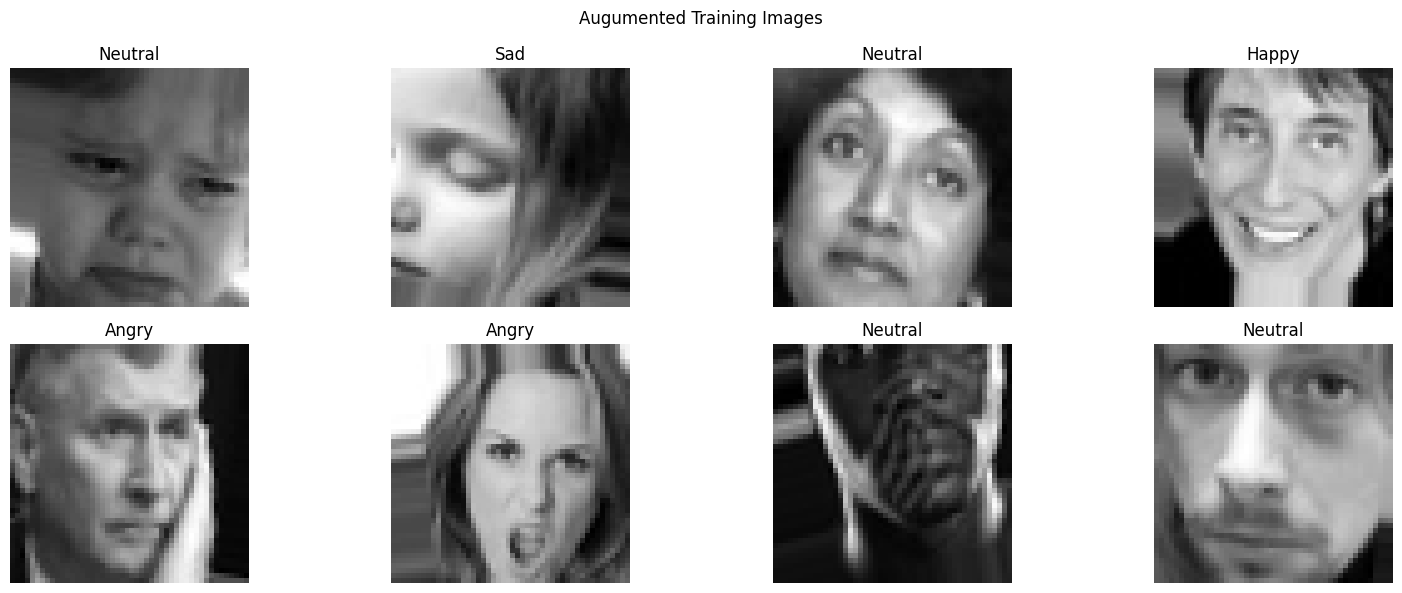

In [89]:
def visualize_augmentation(generator,num_images=8):
    batch_x, batch_y =next(generator)

    fig,axes=plt.subplots(2,num_images//2,figsize=(16,6))
    axes=axes.flatten()

    for i in range(num_images):
        axes[i].imshow(batch_x[i].reshape(image_size,image_size),cmap='gray')
        label_idx=np.argmax(batch_y[i])
        axes[i].set_title(emotions[label_idx].capitalize())
        axes[i].axis('off')

    plt.suptitle('Augumented Training Images')
    plt.tight_layout()
    plt.show()

visualize_augmentation(train_generator)

In [90]:
#Handling Unbalanced Class

In [91]:
from sklearn.utils.class_weight import compute_class_weight

In [92]:
class_labels=train_generator.classes
class_weights=compute_class_weight(
    class_weight='balanced',
    classes=np.unique(class_labels),
    y=class_labels
)

class_weight_dict=dict(enumerate(class_weights))

In [93]:
#Visualize Class Weight

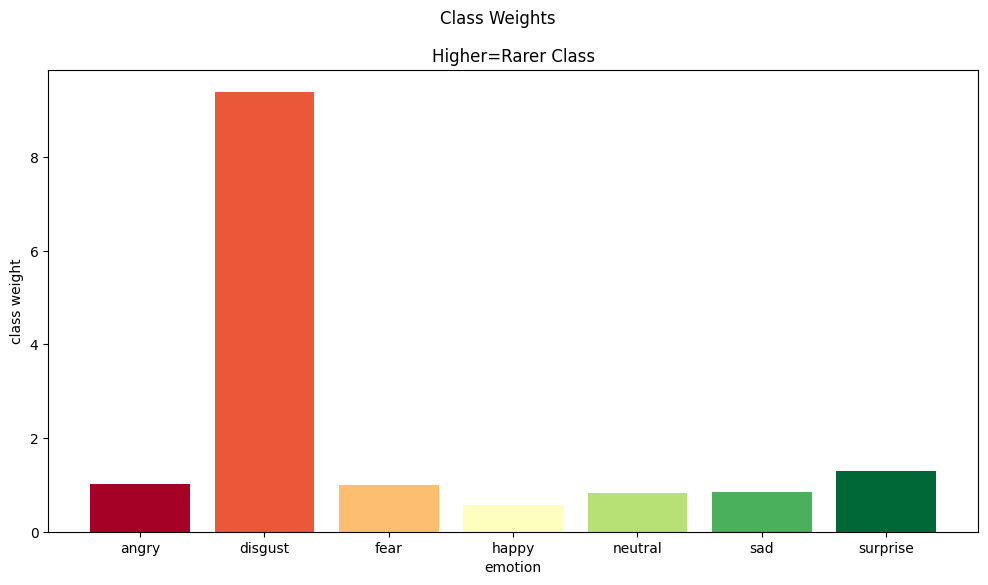

In [94]:
plt.figure(figsize=(12,6))
plt.bar(emotions,class_weights,color=plt.cm.RdYlGn(np.linspace(0,1,len(emotions))))
plt.suptitle('Class Weights')
plt.title('Higher=Rarer Class')
plt.xlabel('emotion')
plt.ylabel('class weight')
plt.show()

In [95]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
     Conv2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization, GlobalAveragePooling2D,Input, Activation, Add)
from tensorflow.keras.regularizers import l2

In [96]:
def build_emotion_cnn(input_shape=(48,48,1),num_classes=7):

    model = Sequential(name='EmotionCNN')
    #Detect Edges, simple textures, basic gradients
    model.add(Conv2D(
        filters=64,
        kernel_size=(3,3),
        padding='same',
        kernel_regularizer=l2(0.001),
        input_shape=input_shape,
        name='conv1_1'
    ))

    model.add(BatchNormalization(name='bn1_1'))
    model.add(Activation('relu',name='relu1_1'))
    #Second  conv layer for more expressive feature extractiom
    model.add(Conv2D(64, (3,3),padding='same',kernel_regularizer=l2(0.001),name='conv1_2'))

    model.add(BatchNormalization(name='bn1_2'))
    model.add(Activation('relu',name='relu1_2'))

    model.add(MaxPooling2D(pool_size=(2,2),name='pool1'))
    model.add(Dropout(0.25,name='droupout1'))

    #Detect Textures Simple Shapes Local Patterns

    model.add(Conv2D(filters=128,kernel_size=(3,3),padding='same',kernel_regularizer=l2(0.001),name='conv2_1'))

    model.add(BatchNormalization(name='bn2_1'))
    model.add(Activation('relu',name='relu2_1'))

    model.add(Conv2D(filters=128,kernel_size=(3,3),padding='same',kernel_regularizer=l2(0.001),name='conv2_2'))

    model.add(BatchNormalization(name='bn2_2'))
    model.add(Activation('relu',name='relu2_2'))

    model.add(MaxPooling2D(pool_size=(2,2),name='pool2'))
    model.add(Dropout(0.25, name='droupout2'))
    #Detect Facial Part
    model.add(Conv2D(filters=256,kernel_size=(3,3),padding='same',kernel_regularizer=l2(0.001),name='conv3_1'))

    model.add(BatchNormalization(name='bn3_1'))
    model.add(Activation('relu',name='relu3_1'))

    model.add(Conv2D(filters=256,kernel_size=(3,5),padding='same',kernel_regularizer=l2(0.001),name='con3_2'))

    model.add(BatchNormalization(name='bn3_2'))
    model.add(Activation('relu',name='relu3_2'))

    model.add(MaxPooling2D(pool_size=(2,2),name='pool3'))
    model.add(Dropout(0.25,name='dropout3'))

    #Detect Expression Specific Pattern , Emotions

    model.add(Conv2D(filters=512,kernel_size=(3,3),padding='same',kernel_regularizer=l2(0.001),name='conv4_1'))

    model.add(BatchNormalization(name='bn4_1'))
    model.add(Activation('relu',name='relu4_1'))

    model.add(Conv2D(filters=512,kernel_size=(3,3),padding='same',kernel_regularizer=l2(0.001),name='conv4_2'))

    model.add(BatchNormalization(name='bn4_2'))
    model.add(Activation('relu',name='relu4_2'))

    model.add(MaxPooling2D(pool_size=(2,2),name='pool4'))
    model.add(Dropout(0.25,name='dropout4'))

    #Convert 3d feature map to 1d vector
    model.add(Flatten(name='flatten'))

    model.add(Dense(512,kernel_regularizer=l2(0.001),name='fc1'))
    model.add(BatchNormalization(name='bn_fc1'))
    model.add(Activation('relu',name='relu_fc1'))
    model.add(Dropout(0.5,name='dropout_fc1'))

    model.add(Dense(256,kernel_regularizer=l2(0.001),name='fc2'))
    model.add(BatchNormalization(name='bn_fc2'))
    model.add(Activation('relu',name='relu_fc2'))
    model.add(Dropout(0.5,name='dropout_fc2'))

    model.add(Dense(num_classes,activation='softmax',name='output'))

    return model


In [97]:
model=build_emotion_cnn()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [98]:
model.summary()

Model: "EmotionCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1_1 (Conv2D)                │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1_1 (BatchNormalization)      │ (None, 48, 48, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu1_1 (Activation)            │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_2 (Conv2D)                │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1_2 (BatchNormalization)      │ (None, 48, 48, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu1_2 (Activation)            │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ droupout1 (Dropout)             │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_1 (Conv2D)                │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2_1 (BatchNormalization)      │ (None, 24, 24, 128)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu2_1 (Activation)            │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_2 (Conv2D)                │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2_2 (BatchNormalization)      │ (None, 24, 24, 128)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu2_2 (Activation)            │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ droupout2 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3_1 (Conv2D)                │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3_1 (BatchNormalization)      │ (None, 12, 12, 256)    │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu3_1 (Activation)            │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ con3_2 (Conv2D)                 │ (None, 12, 12, 256)    │       983,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3_2 (BatchNormalization)      │ (None, 12, 12, 256)    │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu3_2 (Activation)            │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout3 (Dropout)              │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4_1 (Conv2D)                │ (None, 6, 6, 512)      │     1,180,16

 Total params: 7,581,127 (28.92 MB)

 Trainable params: 7,575,751 (28.90 MB)

 Non-trainable params: 5,376 (21.00 KB)

In [99]:
from tensorflow.keras.optimizers import Adam,SGD

In [100]:
model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [101]:
model.count_params()

7581127

In [102]:
from tensorflow.keras. callbacks import (
    EarlyStopping, ReduceLROnPlateau,
    ModelCheckpoint, TensorBoard
)

In [103]:
callbacks=[

    EarlyStopping(monitor='val_loss',patience=15,restore_best_weights=True,verbose=1,mode='min'
    ),
    ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=5,min_lr=1e-7,verbose=1,mode='min'),
    ModelCheckpoint(filepath='best_emotion_model.keras',monitor='val_accuracy',save_best_only=True,verbose=1,mode='max'),
    TensorBoard(log_dir='./logs',histogram_freq=1,write_graph=True)
]

In [104]:
steps_per_epoch=train_generator.samples // batch_size
validation_step = validation_generator.samples // batch_size

In [ ]:
history = model.fit(
    train_generator,
    epochs=100,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_step,
    callbacks=callbacks,
    class_weight=class_weight_dict,  # Handle imbalance
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.1521 - loss: 5.0577
Epoch 1: val_accuracy improved from -inf to 0.17327, saving model to best_emotion_model.keras
381/381 ━━━━━━━━━━━━━━━━━━━━ 133s 288ms/step - accuracy: 0.1521 - loss: 5.0567 - val_accuracy: 0.1733 - val_loss: 3.7830 - learning_rate: 0.0010
Epoch 2/100
  1/381 ━━━━━━━━━━━━━━━━━━━━ 28s 76ms/step - accuracy: 0.1562 - loss: 4.1399

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.17327
381/381 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.1562 - loss: 4.1399 - val_accuracy: 0.1721 - val_loss: 3.7764 - learning_rate: 0.0010
Epoch 3/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.1535 - loss: 3.5499
Epoch 3: val_accuracy did not improve from 0.17327
381/381 ━━━━━━━━━━━━━━━━━━━━ 38s 99ms/step - accuracy: 0.1535 - loss: 3.5492 - val_accuracy: 0.1231 - val_loss: 2.8706 - learning_rate: 0.0010
Epoch 4/100
  1/381 ━━━━━━━━━━━━━━━━━━━━ 27s 73ms/step - accuracy: 0.1875 - loss: 3.2581
Epoch 4: val_accuracy did not improve from 0.17327
381/381 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.1875 - loss: 3.2581 - val_accuracy: 0.1264 - val_loss: 2.8688 - learning_rate: 0.0010
Epoch 5/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.1871 - loss: 2.6644
Epoch 5: val_accuracy improved from 0.17327 to 0.21385, saving model to best_emotion_model.keras
381/381 ━━━━━━━━━━━━━━━━━━━━ 37s 97ms/step - accuracy: 0.

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 38: val_accuracy did not improve from 0.45616
381/381 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.4375 - loss: 1.7750 - val_accuracy: 0.4368 - val_loss: 1.7291 - learning_rate: 2.5000e-04
Epoch 39/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.4759 - loss: 1.6489
Epoch 39: val_accuracy did not improve from 0.45616
381/381 ━━━━━━━━━━━━━━━━━━━━ 40s 104ms/step - accuracy: 0.4759 - loss: 1.6489 - val_accuracy: 0.4494 - val_loss: 1.7282 - learning_rate: 2.5000e-04
Epoch 40/100
  1/381 ━━━━━━━━━━━━━━━━━━━━ 27s 73ms/step - accuracy: 0.4688 - loss: 1.8774

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 40: val_accuracy did not improve from 0.45616
381/381 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.4688 - loss: 1.8774 - val_accuracy: 0.4517 - val_loss: 1.7215 - learning_rate: 2.5000e-04
Epoch 41/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.4728 - loss: 1.6352
Epoch 41: val_accuracy improved from 0.45616 to 0.48531, saving model to best_emotion_model.keras
381/381 ━━━━━━━━━━━━━━━━━━━━ 38s 99ms/step - accuracy: 0.4728 - loss: 1.6352 - val_accuracy: 0.4853 - val_loss: 1.6089 - learning_rate: 2.5000e-04
Epoch 42/100
  1/381 ━━━━━━━━━━━━━━━━━━━━ 28s 75ms/step - accuracy: 0.4375 - loss: 1.8881

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 42: val_accuracy did not improve from 0.48531
381/381 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.4375 - loss: 1.8881 - val_accuracy: 0.4692 - val_loss: 1.6272 - learning_rate: 2.5000e-04
Epoch 43/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.4849 - loss: 1.6399
Epoch 43: val_accuracy improved from 0.48531 to 0.50443, saving model to best_emotion_model.keras
381/381 ━━━━━━━━━━━━━━━━━━━━ 39s 102ms/step - accuracy: 0.4849 - loss: 1.6399 - val_accuracy: 0.5044 - val_loss: 1.5709 - learning_rate: 2.5000e-04
Epoch 44/100
  1/381 ━━━━━━━━━━━━━━━━━━━━ 27s 73ms/step - accuracy: 0.3906 - loss: 2.0991

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 44: val_accuracy did not improve from 0.50443
381/381 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.3906 - loss: 2.0991 - val_accuracy: 0.5028 - val_loss: 1.5616 - learning_rate: 2.5000e-04
Epoch 45/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.4974 - loss: 1.5914
Epoch 45: val_accuracy did not improve from 0.50443
381/381 ━━━━━━━━━━━━━━━━━━━━ 41s 108ms/step - accuracy: 0.4974 - loss: 1.5914 - val_accuracy: 0.4967 - val_loss: 1.5676 - learning_rate: 2.5000e-04
Epoch 46/100
  1/381 ━━━━━━━━━━━━━━━━━━━━ 27s 74ms/step - accuracy: 0.4844 - loss: 1.7392

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 46: val_accuracy improved from 0.50443 to 0.50979, saving model to best_emotion_model.keras
381/381 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.4844 - loss: 1.7392 - val_accuracy: 0.5098 - val_loss: 1.5478 - learning_rate: 2.5000e-04
Epoch 47/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.5004 - loss: 1.5996
Epoch 47: val_accuracy did not improve from 0.50979
381/381 ━━━━━━━━━━━━━━━━━━━━ 82s 126ms/step - accuracy: 0.5004 - loss: 1.5996 - val_accuracy: 0.5079 - val_loss: 1.5926 - learning_rate: 2.5000e-04
Epoch 48/100
  1/381 ━━━━━━━━━━━━━━━━━━━━ 27s 73ms/step - accuracy: 0.5000 - loss: 1.4933

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 48: val_accuracy improved from 0.50979 to 0.51026, saving model to best_emotion_model.keras
381/381 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.5000 - loss: 1.4933 - val_accuracy: 0.5103 - val_loss: 1.5942 - learning_rate: 2.5000e-04
Epoch 49/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.5058 - loss: 1.5942
Epoch 49: val_accuracy did not improve from 0.51026
381/381 ━━━━━━━━━━━━━━━━━━━━ 38s 99ms/step - accuracy: 0.5058 - loss: 1.5942 - val_accuracy: 0.5026 - val_loss: 1.5821 - learning_rate: 2.5000e-04
Epoch 50/100
  1/381 ━━━━━━━━━━━━━━━━━━━━ 28s 75ms/step - accuracy: 0.4531 - loss: 1.6502

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 50: val_accuracy did not improve from 0.51026
381/381 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.4531 - loss: 1.6502 - val_accuracy: 0.5077 - val_loss: 1.5779 - learning_rate: 2.5000e-04
Epoch 51/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.5144 - loss: 1.5416
Epoch 51: val_accuracy improved from 0.51026 to 0.51796, saving model to best_emotion_model.keras
381/381 ━━━━━━━━━━━━━━━━━━━━ 38s 99ms/step - accuracy: 0.5144 - loss: 1.5417 - val_accuracy: 0.5180 - val_loss: 1.5414 - learning_rate: 2.5000e-04
Epoch 52/100
  1/381 ━━━━━━━━━━━━━━━━━━━━ 27s 72ms/step - accuracy: 0.5469 - loss: 1.3751

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 52: val_accuracy did not improve from 0.51796
381/381 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.5469 - loss: 1.3751 - val_accuracy: 0.5170 - val_loss: 1.5660 - learning_rate: 2.5000e-04
Epoch 53/100
271/381 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - accuracy: 0.5163 - loss: 1.5386